In [2]:
#Download dataset from Roboflow
!pip install roboflow ultralytics -q

!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="6plXXWjqcqmkMVJnbM2i")
project = rf.workspace("pensdatasetobjectdetection").project("handgestures-bsylk")
version = project.version(1)
dataset = version.download("yolov8")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 52.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 60.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 94.2 MB/s eta 0:00:00
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Handgestures-1 in yolov8:: 100%|██████████| 96/96 [00:00<00:00, 1297.86it/s]


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [6]:
# Step 3️⃣A: Train YOLOv8 model
from ultralytics import YOLO

model = YOLO('yolov8n.pt')  # or yolov8s.pt for better accuracy

# Train
model.train(
    data=dataset.location + '/data.yaml',
    epochs=25,
    imgsz=640,
    batch=16,
    name=PROJECT_NAME.replace(" ", "_")
)


Ultralytics 8.3.223 🚀 Python-3.12.12 torch-2.8.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Handgestures-1/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=Handgestures, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plot

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x785419d20d70>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

In [10]:
# Step 3️B: Train CNN for classification



import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = dataset.location + "/train"
val_dir = dataset.location + "/valid"

datagen = ImageDataGenerator(rescale=1./255)

train_data = datagen.flow_from_directory(train_dir, target_size=(128, 128), batch_size=32, class_mode='categorical')
val_data = datagen.flow_from_directory(val_dir, target_size=(128, 128), batch_size=32, class_mode='categorical')

model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(train_data.num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_data, validation_data=val_data, epochs=20)


Found 29 images belonging to 2 classes.
Found 9 images belonging to 2 classes.


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.


Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.9310 - loss: 0.6452 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 909ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 909ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 880ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.00

In [13]:
# Step 4️A (Fixed): Evaluate CNN model performance

# Evaluate accuracy & loss on validation data
val_loss, val_acc = model.evaluate(val_data)
print(f" Validation Accuracy: {val_acc*100:.2f}%")
print(f" Validation Loss: {val_loss:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 0.0000e+00
 Validation Accuracy: 100.00%
 Validation Loss: 0.0000


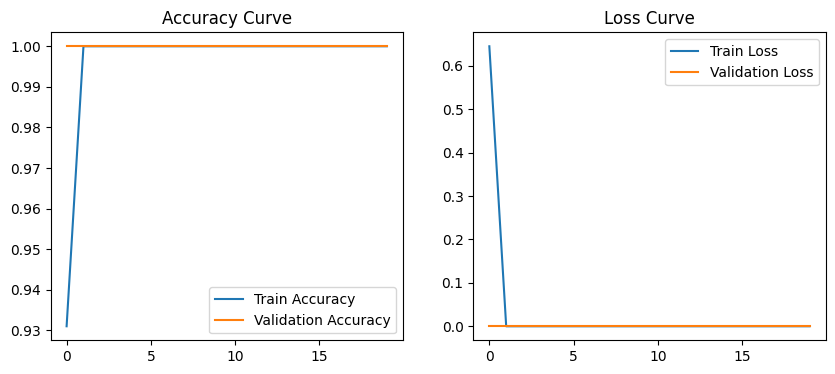

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Accuracy Curve")

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Loss Curve")
plt.show()


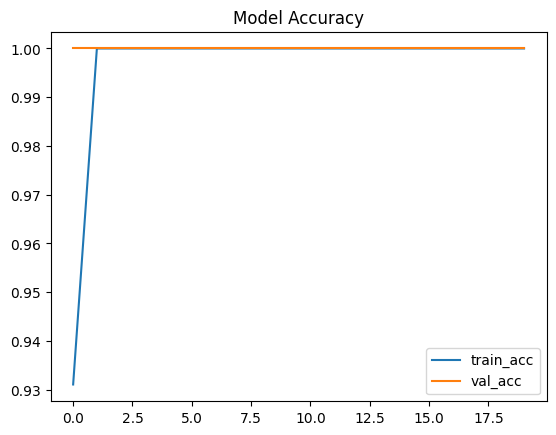

In [15]:
# Step 4️B: Plot accuracy & loss curves
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.title("Model Accuracy")
plt.show()


In [22]:
from ultralytics import YOLO
model = YOLO("yolov8n.pt")  # or your trained .pt file

results = model.predict(source=frame, stream=False)
annotated_frame = results[0].plot()


WARNING ⚠️ 'source' is missing. Using 'source=/usr/local/lib/python3.12/dist-packages/ultralytics/assets'.

image 1/2 /usr/local/lib/python3.12/dist-packages/ultralytics/assets/bus.jpg: 640x480 4 persons, 1 bus, 1 stop sign, 265.8ms
image 2/2 /usr/local/lib/python3.12/dist-packages/ultralytics/assets/zidane.jpg: 384x640 2 persons, 1 tie, 214.8ms
Speed: 7.2ms preprocess, 240.3ms inference, 3.8ms postprocess per image at shape (1, 3, 384, 640)


Saving sample.jpg to sample (1).jpg

0: 384x640 2 persons, 1 tie, 190.3ms
Speed: 6.6ms preprocess, 190.3ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


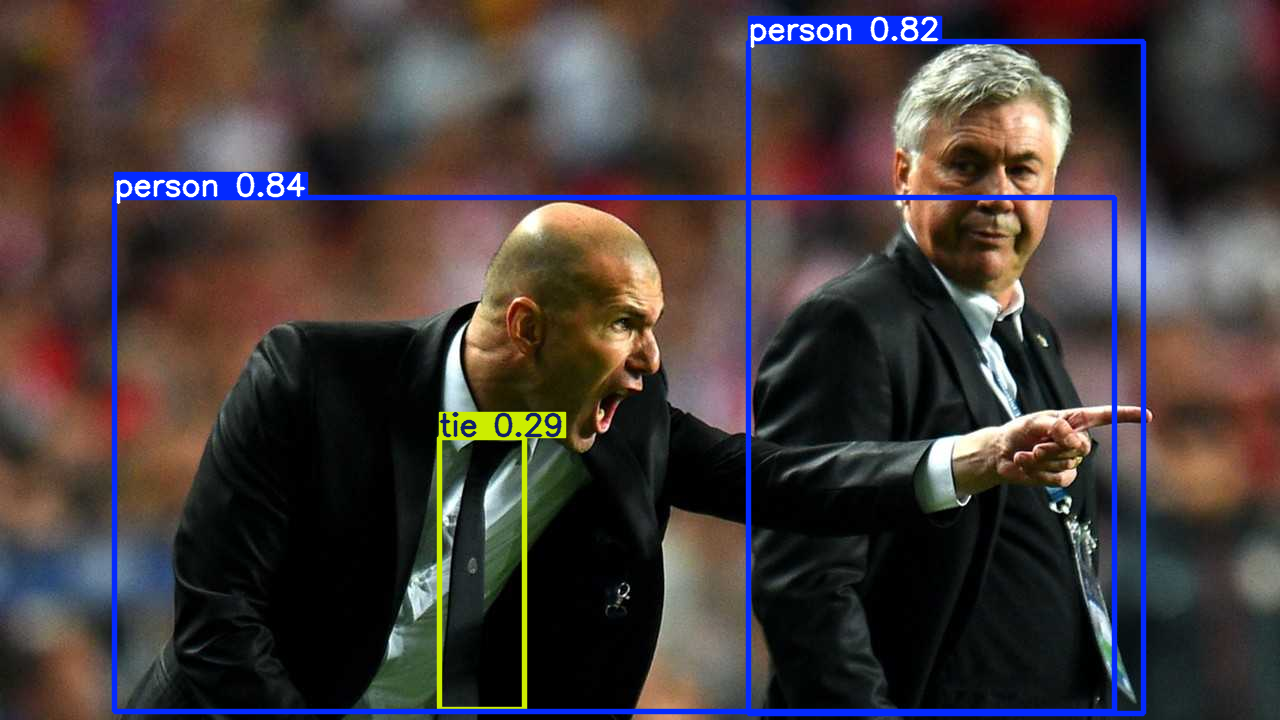

In [27]:
from ultralytics import YOLO
import cv2
from google.colab.patches import cv2_imshow

# Load model
model = YOLO("yolov8n.pt")

# Upload image
from google.colab import files
uploaded = files.upload()

# Pick the first uploaded file
image_path = list(uploaded.keys())[0]

# Read and run inference
img = cv2.imread(image_path)
results = model(img)
annotated = results[0].plot()

# Display
cv2_imshow(annotated)


Saving sample.jpg to sample (3).jpg

image 1/1 /content/sample (3).jpg: 384x640 2 persons, 1 tie, 162.2ms
Speed: 4.6ms preprocess, 162.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)
Results saved to /content/runs/detect/predict


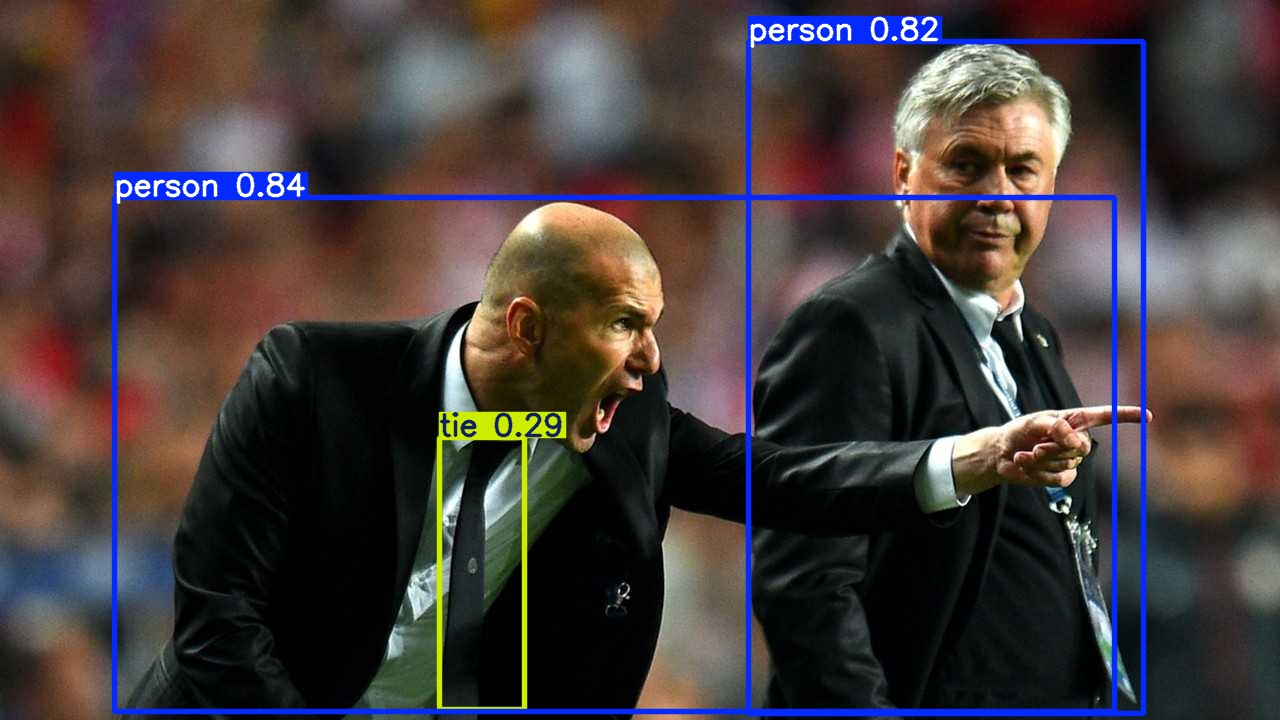

In [30]:
from ultralytics import YOLO

# Load YOLOv8 model
model = YOLO("yolov8n.pt")  # or your trained .pt model

# Run prediction on uploaded image
from google.colab import files
uploaded = files.upload()
image_path = list(uploaded.keys())[0]

# Run YOLOv8 inference correctly
results = model.predict(source=image_path, save=True, show=False)

# Display output
from IPython.display import Image, display
display(Image(filename=f"runs/detect/predict/{image_path}"))
